# Configuración (importar dependencias, librerías, ...)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Hiperparámetros
# model_checkpoint = 'xlm-roberta-base'
model_checkpoint = 'bert-base-uncased'
# model_checkpoint = 'roberta-base'

In [80]:
!pip install pytorch-lightning

In [81]:
# Set the seed value all over the place to make this reproducible.
# esto hay que ponerlo justo antes de importar para que los experimentos
# sean reproducible

import random
import torch
import numpy as np
import os
from pytorch_lightning import seed_everything

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)# Store the average loss after eachepoch so we can plot them.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["TF_DETERMINISTIC_OPS"] = "1" # See:https://github.com/NVIDIA/tensorflow-determinism#confirmed-current-gpu-specific-sources-of-non-determinism-with-solutions
seed_everything(42, workers=True)

!pip install transformers datasets
!pip install --upgrade accelerate
!pip install sentencepiece
!pip install contractions
!pip install textblob
!pip install accelerate -U
!pip install optuna
from datasets import Dataset, DatasetDict, load_metric
import pandas as pd
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
 TrainingArguments, Trainer, pipeline, EarlyStoppingCallback

INFO:lightning_fabric.utilities.seed:Seed set to 42


  Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [6]:
import torch

# Verificar si CUDA está disponible
if torch.cuda.is_available():
    # Obtener el nombre de la GPU
    gpu_name = torch.cuda.get_device_name(0)

    # Obtener la capacidad de la GPU
    gpu_capability = torch.cuda.get_device_capability(0)

    # Obtener la memoria total y disponible en la GPU
    gpu_memory_info = torch.cuda.get_device_properties(0)

    print(f"GPU Name: {gpu_name}")
    print(f"GPU Capability: {gpu_capability[0]}.{gpu_capability[1]}")
    print(f"Total GPU Memory: {gpu_memory_info.total_memory / (1024**3):.2f} GB")
    print(f"Free GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3) - torch.cuda.memory_allocated() / (1024**3):.2f} GB")
else:
    print("CUDA not available. Make sure your Jupyter Notebook is running with a GPU kernel.")

GPU Name: Tesla T4
GPU Capability: 7.5
Total GPU Memory: 14.75 GB
Free GPU Memory: 14.75 GB


In [7]:
# Check that pyTorch is identifying the GPU
if torch.cuda.device_count() > 0:
  print(f'GPU detected. Currently using: "{torch.cuda.get_device_name(0)}"')
else:
  print('Currently using CPU, change the type of the runtime in the \'runtime\' tab')

GPU detected. Currently using: "Tesla T4"


# Preparación de los datos

## Lectura de los ficheros

In [10]:
# Cargamos los datos de entrenamiento y test
# data_path = './'
data_path = '/content/drive/MyDrive/TFG/Training Data/'

# Los pasamos a dataframes
train_df = pd.read_csv(data_path + 'train.csv', encoding = 'UTF-8', sep=',')
# test_df = pd.read_csv(data_path + 'test_df.csv', encoding = 'UTF-8', sep=',')
# valid_df = pd.read_csv(data_path + 'valid_df.csv', encoding = 'UTF-8', sep=',')

nombre_etiqueta = 'stereotype'
campo_texto = 'text'

In [11]:
# Para saber el número de filas de cada clase en cada división
print("Distribución original - Train: ", train_df.value_counts(nombre_etiqueta))
# print("Distribución original - Valid: ", valid_df.value_counts(nombre_etiqueta))
# print("Distribución original - Test: ", test_df.value_counts(nombre_etiqueta))

Distribución original - Train:  stereotype
0    7301
1    2605
dtype: int64


## Reducción de los ficheros

In [12]:
porcentaje = 0.2

In [13]:
t1, t2 = train_test_split(train_df, test_size = 1 - porcentaje, stratify = train_df[nombre_etiqueta])
# v1, v2 = train_test_split(valid_df, test_size = 1 - porcentaje, stratify = valid_df[nombre_etiqueta])

train_df_reduced = t1
# valid_df_reduced = v1

In [14]:
red_path = '/content/drive/MyDrive/TFG/Training Data/Reducido/'

train_df_reduced.to_csv(red_path + "train_df_reducido.csv", index=False)
# valid_df_reduced.to_csv(red_path + "valid_df_reducido.csv", index=False)

## Lectura de ficheros reducidos

In [15]:
# data_path = './'
data_path = '/content/drive/MyDrive/TFG/Training Data/Reducido/'

train_df = pd.read_csv(data_path + 'train_df_reducido.csv', encoding = 'UTF-8', sep=',')
# test_df = pd.read_csv(data_path + 'test_df.csv', encoding = 'UTF-8', sep=',')
# valid_df = pd.read_csv(data_path + 'valid_df_reducido.csv', encoding = 'UTF-8', sep=',')

nombre_etiqueta = 'stereotype'
campo_texto = 'text'

In [16]:
# Para saber el número de filas de cada clase en cada división
print("Distribución original - Train: ", train_df.value_counts(nombre_etiqueta))
# print("Distribución original - Valid: ", valid_df.value_counts(nombre_etiqueta))
# print("Distribución original - Test: ", test_df.value_counts(nombre_etiqueta))

Distribución original - Train:  stereotype
0    1460
1     521
dtype: int64


## Limpieza de datos

In [17]:
# Esto solo es para ver la longitud (en palabras) de los tweets
def divide(texto):
  return texto.split()

def cuenta_tokens(lista):
  return len(lista)

train_df_palabras = train_df.copy()
train_df_palabras['text_split'] = train_df_palabras[campo_texto].apply(divide)
train_df_palabras['num_palabras'] = train_df_palabras['text_split'].apply(cuenta_tokens)
train_df_palabras

,source,id,comment_id,text,level1,level2,level3,level4,stereotype_a1,stereotype_a2,stereotype_a3,stereotype,stereotype_soft,implicit_a1,implicit_a2,implicit_a3,implicit,implicit_soft,text_split,num_palabras
0,detests,d_1929_02,d_1929,"Marruecos es cada día más un país agresor, mie...",d_1929_01,d_208,d_208,ABC20211105,0,0,0,0,0.0474,0,0,0,0,0.0474,"[Marruecos, es, cada, día, más, un, país, agre...",21
1,detests,d_91_02,d_91,¿Quieres prohibir derechos a quien a TI no te ...,d_91_01,d_2,d_51,20170819_CR,0,0,0,0,0.0474,0,0,0,0,0.0474,"[¿Quieres, prohibir, derechos, a, quien, a, TI...",10
2,detests,d_1724_01,d_1724,Señores tenemos un sosiata ganador.,0,d_2,d_234,ABC20211105,0,0,0,0,0.0474,0,0,0,0,0.0474,"[Señores, tenemos, un, sosiata, ganador.]",5
3,stereohoax,s_2032,s_2032,Osea que la ministra no quiere derogar la ley ...,0,s_2017,s_1987,SP043,0,0,0,0,0.0474,0,0,0,0,0.0474,"[Osea, que, la, ministra, no, quiere, derogar,...",29
4,stereohoax,s_3569,s_3569,Me cojo la pasta y me piro a Alaska,0,s_3291,s_3291,SP036,0,0,0,0,0.0474,0,0,0,0,0.0474,"[Me, cojo, la, pasta, y, me, piro, a, Alaska]",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,stereohoax,s_3402,s_3402,Mira el Vago de Abascalete... se cree que sabe...,0,s_3291,s_3291,SP036,0,0,0,0,0.0474,0,0,0,0,0.0474,"[Mira, el, Vago, de, Abascalete..., se, cree, ...",16
1977,detests,d_615_02,d_615,No hay dinero.,d_615_01,d_567,d_567,20200708_MI,0,0,1,0,0.2689,0,0,1,0,0.2689,"[No, hay, dinero.]",3
1978,stereohoax,s_2349,s_2349,"Te dejas a @user , que vende muy bien televisi...",0,s_1765,s_1748,SP043,0,0,0,0,0.0474,0,0,0,0,0.0474,"[Te, dejas, a, @user, ,, que, vende, muy, bien...",10
1979,detests,d_833_03,d_833,Y de que viven si no pueden trabajar?,d_833_02,0,0,20200708_MI,1,0,0,0,0.2689,1,0,0,0,0.2689,"[Y, de, que, viven, si, no, pueden, trabajar?]",8


In [18]:
max = train_df_palabras.max()['num_palabras']
print(f'El texto de mayor longitud tiene {max} palabras')

El texto de mayor longitud tiene 120 palabras


In [20]:
# Se convierten los dataframes en objetos datasets para que los acepten los transformers
train_dataset = Dataset.from_pandas(train_df)
# valid_dataset = Dataset.from_pandas(valid_df)
# test_dataset = Dataset.from_pandas(test_df)

# print(train_dataset, valid_dataset, test_dataset)
print(train_dataset)

Dataset({
    features: ['source', 'id', 'comment_id', 'text', 'level1', 'level2', 'level3', 'level4', 'stereotype_a1', 'stereotype_a2', 'stereotype_a3', 'stereotype', 'stereotype_soft', 'implicit_a1', 'implicit_a2', 'implicit_a3', 'implicit', 'implicit_soft'],
    num_rows: 1981
})


In [21]:
# Los objetos de tipo Dataset también se pueden mostrar en formato pandas
train_dataset.set_format("pandas")
train_dataset[:]

,source,id,comment_id,text,level1,level2,level3,level4,stereotype_a1,stereotype_a2,stereotype_a3,stereotype,stereotype_soft,implicit_a1,implicit_a2,implicit_a3,implicit,implicit_soft
0,detests,d_1929_02,d_1929,"Marruecos es cada día más un país agresor, mie...",d_1929_01,d_208,d_208,ABC20211105,0,0,0,0,0.0474,0,0,0,0,0.0474
1,detests,d_91_02,d_91,¿Quieres prohibir derechos a quien a TI no te ...,d_91_01,d_2,d_51,20170819_CR,0,0,0,0,0.0474,0,0,0,0,0.0474
2,detests,d_1724_01,d_1724,Señores tenemos un sosiata ganador.,0,d_2,d_234,ABC20211105,0,0,0,0,0.0474,0,0,0,0,0.0474
3,stereohoax,s_2032,s_2032,Osea que la ministra no quiere derogar la ley ...,0,s_2017,s_1987,SP043,0,0,0,0,0.0474,0,0,0,0,0.0474
4,stereohoax,s_3569,s_3569,Me cojo la pasta y me piro a Alaska,0,s_3291,s_3291,SP036,0,0,0,0,0.0474,0,0,0,0,0.0474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,stereohoax,s_3402,s_3402,Mira el Vago de Abascalete... se cree que sabe...,0,s_3291,s_3291,SP036,0,0,0,0,0.0474,0,0,0,0,0.0474
1977,detests,d_615_02,d_615,No hay dinero.,d_615_01,d_567,d_567,20200708_MI,0,0,1,0,0.2689,0,0,1,0,0.2689
1978,stereohoax,s_2349,s_2349,"Te dejas a @user , que vende muy bien televisi...",0,s_1765,s_1748,SP043,0,0,0,0,0.0474,0,0,0,0,0.0474
1979,detests,d_833_03,d_833,Y de que viven si no pueden trabajar?,d_833_02,0,0,20200708_MI,1,0,0,0,0.2689,1,0,0,0,0.2689


In [ ]:
# Se pueden eliminar los dataframes puesto que no se van a usar más
del train_df
# del valid_df
# del test_df

# Preparación de los conjuntos para el entrenamiento

In [22]:
# Se asigna una etiqueta numérica en función de la etiqueta principal

def set_labels(records):
  if records[nombre_etiqueta] == 'not sexist':
    label = 0
  else:
    label = 1
  return {'labels': label}

In [23]:
# Reseteamos el formato para que no haya fallos
train_dataset.reset_format()
# valid_dataset.reset_format()
# test_dataset.reset_format()

In [24]:
# Map the functions to the dataset
train_dataset = train_dataset.map(set_labels)
# valid_dataset = valid_dataset.map(set_labels)

# print(train_dataset, valid_dataset)
print(train_dataset)

Map:   0%|          | 0/1981 [00:00<?, ? examples/s]

Dataset({
    features: ['source', 'id', 'comment_id', 'text', 'level1', 'level2', 'level3', 'level4', 'stereotype_a1', 'stereotype_a2', 'stereotype_a3', 'stereotype', 'stereotype_soft', 'implicit_a1', 'implicit_a2', 'implicit_a3', 'implicit', 'implicit_soft', 'labels'],
    num_rows: 1981
})


In [25]:
# Reseteamos el formato para que no haya fallos
train_dataset.reset_format()
# valid_dataset.reset_format()
# test_dataset.reset_format()

# Proceso de clasificación

## Tokenización

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [27]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
# Tamaño del vocabulario del tokenizador
tokenizer.vocab_size

30522

In [29]:
# Crear un contenedor para los conteos de tokens por tweet
conteos_token_train = []
# conteos_token_valid = []
# Tokenizar todos los tweets y registrar el número de tokens
for tweet in tqdm(train_dataset):
    tokens = tokenizer.tokenize(tweet[campo_texto])
    conteos_token_train.append(len(tokens))
# for tweet in tqdm(valid_dataset):
#     tokens = tokenizer.tokenize(tweet[campo_texto])
#     conteos_token_valid.append(len(tokens))

100%|██████████| 1981/1981 [00:01<00:00, 1613.88it/s]


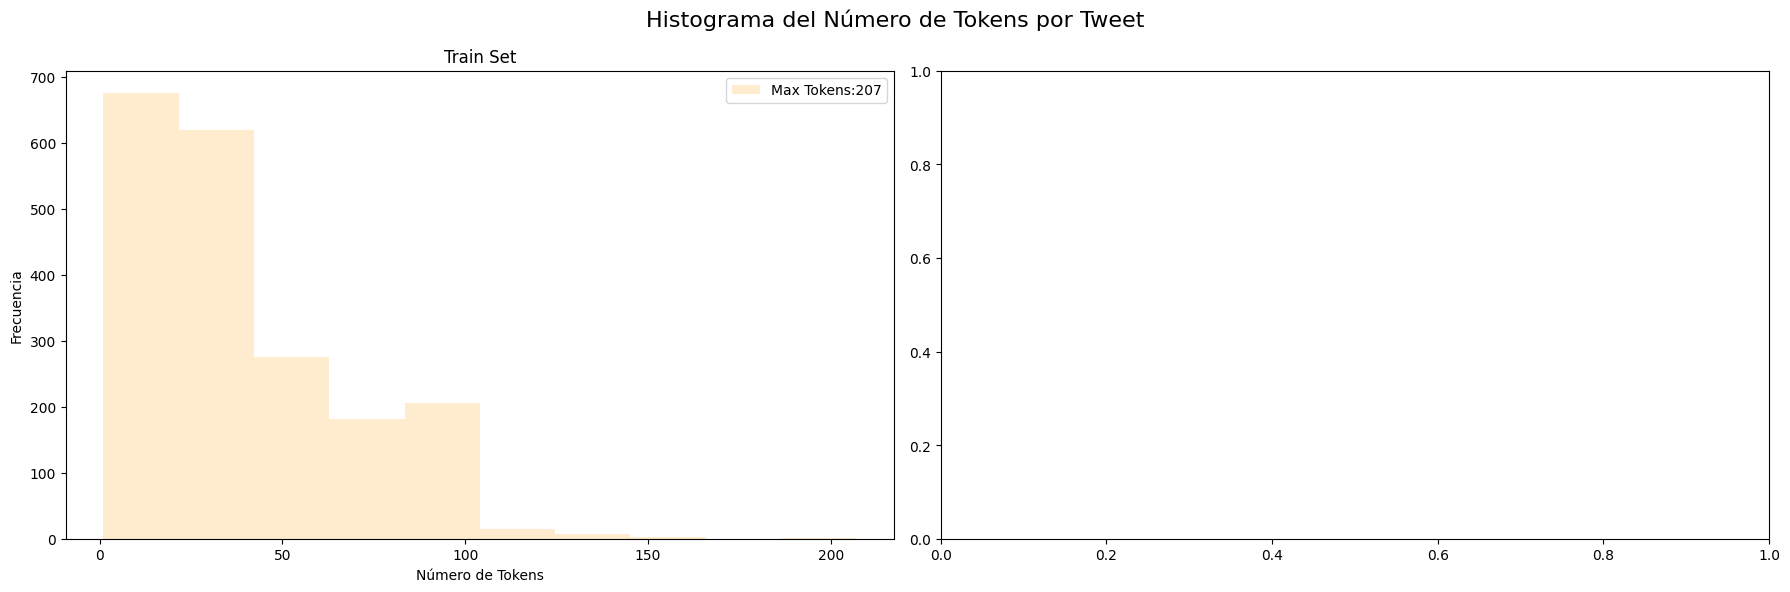

In [30]:
del max

# Crear subgráficos
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
fig.suptitle('Histograma del Número de Tokens por Tweet', fontsize = 16)

# Subgráfico para el conjunto train
max_tokens_train = max(conteos_token_train)
axes[0].hist(conteos_token_train, color='blanchedalmond')
axes[0].set_title('Train Set')
axes[0].set_xlabel('Número de Tokens')
axes[0].set_ylabel('Frecuencia')
axes[0].legend(['Max Tokens:' + str(max_tokens_train)])

# # Subgráfico para el conjunto valid
# max_tokens_valid = max(conteos_token_valid)
# axes[1].hist(conteos_token_valid, color='lightpink')
# axes[1].set_title('Valid Set')
# axes[1].set_xlabel('Número de Tokens')
# axes[1].set_ylabel('Frecuencia')
# axes[1].legend(['Max Tokens:' + str(max_tokens_valid)])

# Ajustar el diseño y mostrar los subgráficos
plt.tight_layout()
plt.show()

#### *Definir Longitud Máxima*

In [31]:
# Definir MAX_LENGTH
MAX_LENGTH = 128

In [32]:
# Función para tokenizar un dataset
def tokenize_data(examples):
  #return tokenizer(examples[campo_texto], truncation=True, padding='longest')
  return tokenizer(examples[campo_texto], truncation=True, max_length=MAX_LENGTH, padding=True)

In [34]:
# Celda para para construir los ficheros codificados (encoded)
columns_train = train_dataset.column_names  # Coge todas las columnas
# columns_valid = valid_dataset.column_names  # Coge todas las columnas
columns_train.remove("labels") # Elimina la columna "labels"
# columns_valid.remove("labels") # Elimina la columna "labels"

# Hace el tokenizado y elimina todas las columnas que no se necesitan
encoded_train_dataset = train_dataset.map(tokenize_data, batched=True, remove_columns=columns_train)
# encoded_valid_dataset = valid_dataset.map(tokenize_data, batched=True, remove_columns=columns_valid)
encoded_train_dataset

Map:   0%|          | 0/1981 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1981
})

In [35]:
len(encoded_train_dataset[3]['input_ids'])

128

In [ ]:
encoded_train_dataset[4]['input_ids']

In [ ]:
encoded_train_dataset[4]

## Carga del modelo

In [38]:
# Se carga el modelo preentrenado
n_labels = 2
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                                              num_labels = n_labels)
                                                              # use_auth_token = 'token propio de HugginFace')

In [39]:
# Para saber el nombre del modelo
model_name = model_checkpoint.split("/")[-1]
model_name

'bert-base-uncased'

## Definición de la métricas

In [40]:
# Función para realizar distintas métricas en ejecución

def compute_metrics(eval_pred):

  ##############
  ## preds son logits, que son tuplas de la forma [valor1, valor2]
  ## Por ejemplo [-1.5606991,  1.6122842] significa que ha predicho eso para un documento
  ## Eso es lo que pasa a la última capa del transformer (softmax si es binario)
  ## Por eso se utiliza el índice del valor máximo de la tupla, para decir que esa es la clase que predice
  ##############

  labels = eval_pred.label_ids
  preds = eval_pred.predictions.argmax(-1)

  precision, recall, f1, _ = sk.metrics.precision_recall_fscore_support(labels, preds, average="macro")
  f1_minoritaria = f1_score(labels, preds, pos_label=1)
  f1_mayoritaria = f1_score(labels, preds, pos_label=0)
  acc = sk.metrics.accuracy_score(labels, preds)
  AUC = roc_auc_score(labels, preds)
  PREC_REC = average_precision_score(labels, preds)
  return { 'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall, 'AUC': AUC,
           'f1_minoritaria': f1_minoritaria, 'f1_mayoritaria': f1_mayoritaria, 'PREC_REC': PREC_REC }

In [ ]:
##### Otra forma de definir las métricas
'''
accuracy = load_metric('accuracy')
f1 = load_metric('f1')

def compute_metric(eval_pred, test=False):
  predictions, labels = eval_pred

  if test == False:
    predictions = np.argmax(predictions, axis=1)

  result_acc = accuracy.compute(predictions=predictions, references=labels)['accuracy']
  result_f1 = f1.compute(predictions=predictions, references=labels)['f1']

  return {'accuracy': result_acc, 'f1-score': result_f1}
  '''
##### Otra forma de definir las métricas

## Configuración de la búsqueda de hiperparámetros

#### *Definir el Número de Épocas*

In [41]:
# Definir NUM_TRAIN_EPOCHS
NUM_TRAIN_EPOCHS = 20

In [42]:
import optuna
from functools import partial

In [43]:
def maximum(a, b):
    if a >= b:
        return a
    else:
        return b

#### *Estructura de Búsqueda*

In [44]:
# Crear un espacio de búsqueda de hiperparámetros
search_space = {
    "per_device_train_batch_size": [16, 32],
    "learning_rate": [3e-5, 5e-5],
    "weight_decay": [0.01, 0.1],
}

In [45]:
# Calcular Numero de busquedas
nbusquedas = 1
for options in search_space.values():
    nbusquedas *= len(options)

In [65]:
# Función objetivo para Optuna
def compute_objective(trial):

    # Obtener los hiperparámetros sugeridos por Optuna
    # hparams = optuna_hp_space(trial)
    hparams = {key: trial.suggest_categorical(key, values) for key, values in search_space.items()}

    # Se definen los parámetros del Trainer()
    num_train_samples = int(len(encoded_train_dataset))
    # num_evaluation= int(len(encoded_valid_dataset))

    value = len(encoded_train_dataset) // (2 * hparams["per_device_train_batch_size"] * NUM_TRAIN_EPOCHS)
    logging_steps = maximum(1, value)

    optim = ["adamw_hf", "adamw_torch", "adamw_apex_fused", "adafactor", "adamw_torch_xla"]

    training_args = TrainingArguments(
        output_dir='results',
        num_train_epochs=NUM_TRAIN_EPOCHS,
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["per_device_train_batch_size"],
        per_device_eval_batch_size=hparams["per_device_train_batch_size"],
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        weight_decay=hparams["weight_decay"],
        evaluation_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=3,
        optim=optim[1],
        push_to_hub=False
    )

    # Configurar el objeto Trainer con los hiperparámetros dados
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        train_dataset=encoded_train_dataset,
        # eval_dataset=encoded_valid_dataset,
        tokenizer=tokenizer,
    )

    # Entrenar el modelo y obtener la métrica de interés
    trainer.train()

    # Evaluar el modelo en el conjunto de validación
    result = trainer.evaluate()
    print(result)

    # Obtener la métrica de interés, en este caso, F1
    metric = result['eval_f1']

    # Devolver la métrica como resultado para la optimización de Optuna
    return metric

In [48]:
best_number = 0
best_result = 0

# ruta_callback = './hp/'
ruta_callback = '/content/drive/MyDrive/TFG/Training Data/Hiperparametros/'

# Callback para guardar los resultados en cada iteración
def callback(study, trial, busqueda, modelo):
    # Obtener la información relevante de la iteración actual
    trial_value = trial.value
    trial_params = trial.params

    global best_result, best_number

    # Actualizar el mejor resultado
    if trial_value > best_result:
        best_number = trial.number
        best_result = trial_value

    # Guardar los resultados en un archivo o en cualquier otra estructura de datos
    with open(ruta_callback + 'hiperparametros_' + busqueda +'_' + modelo +'.txt', 'a') as f:
        if trial.number == 0:
            f.write(f"Estudio de Hiperparámetros. Búsqueda: {busqueda}, Modelo: {modelo}\n\n")
        f.write(f"Iteración: {trial.number}, Valor: {trial_value}, HP: {trial_params}, Mejor: {best_number}\n")

## Estudio de hiperparámetros

In [ ]:
# # Búsqueda heurística
# metodo = 'heuristica'
# study = optuna.create_study(direction='maximize')

In [ ]:
# # Búsqueda aleatoria
# metodo = 'aleatoria'
# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(), direction='maximize')

In [49]:
# Búsqueda exhaustiva
metodo = 'exhaustiva'
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))

[I 2024-03-06 16:17:16,605] A new study created in memory with name: no-name-2d69e312-296d-463e-9b25-54c33844e52b


In [50]:
# Obtener nombre del modelo acortado
model_short = model_name.split("-")[0]
# model_short = 'prueba'
model_short

'bert'

In [64]:
# Crear una versión de callback con argumentos fijos
partial_callback = partial(callback, busqueda=metodo, modelo=model_short)

In [83]:
# Realizar la optimización de hiperparámetros
study.optimize(compute_objective, n_trials=nbusquedas, callbacks=[partial_callback])

[W 2024-03-06 17:18:31,648] `GridSampler` is re-evaluating a configuration because the grid has been exhausted. This may happen due to a timing issue during distributed optimization or when re-running optimizations on already finished studies.
[W 2024-03-06 17:18:31,651] Trial 11 failed with parameters: {'per_device_train_batch_size': 16, 'learning_rate': 3e-05, 'weight_decay': 0.01} because of the following error: ImportError('Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-65-ded77da16e44>", line 17, in compute_objective
    training_args = TrainingArguments(
  File "<string>", line 123, in __init__
  File "/usr/local/lib/python3.10/dist-packages/transformers/training_args.py", line 1528, in __post_i

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)